In [ ]:
pip install transformers datasets accelerate evaluate jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import random
import numpy as np
import evaluate
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from jiwer import wer
from transformers import  AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer

In [ ]:
# Load the dataset and preform train test slpit
dataset = load_dataset("YaYaB/onepiece-blip-captions")

dataset = dataset ["train"].train_test_split(test_size=0.1, seed=42)
train = dataset["train"]
test = dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/856 [00:00<?, ? examples/s]

In [ ]:
# Transform the data into the appropriate format

processor = AutoProcessor.from_pretrained("microsoft/git-base")

def transforms(example_batch):
 images = [x for x in example_batch["image"]]
 captions = [x for x in example_batch["text"]]
 inputs = processor(images=images, text=captions, padding="max_length")
 inputs.update({"labels": inputs["input_ids"]})
 return inputs

train.set_transform(transforms)
test.set_transform(transforms)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Set up evaluation metrics
wer = evaluate.load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [ ]:
# Training arguments configuration for the model

training_args = TrainingArguments(
    output_dir="./model_output",
    learning_rate=5e-5,
    num_train_epochs=10,
    per_device_train_batch_size=5,
    gradient_accumulation_steps=6,
    save_total_limit=3,
    save_strategy="steps",
    save_steps=10,
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
)

model=AutoModelForCausalLM.from_pretrained("microsoft/git-base")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=test,
    compute_metrics=compute_metrics,
)

trainer.train()

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
5,10.217500
10,8.820400
15,8.202200
20,7.720200
25,7.264700
30,6.811500
35,6.353000
40,5.901600
45,5.451800
50,5.001500


TrainOutput(global_step=250, training_loss=2.09445802628994, metrics={'train_runtime': 1413.9629, 'train_samples_per_second': 5.446, 'train_steps_per_second': 0.177, 'total_flos': 3507619783680000.0, 'train_loss': 2.09445802628994, 'epoch': 9.74})

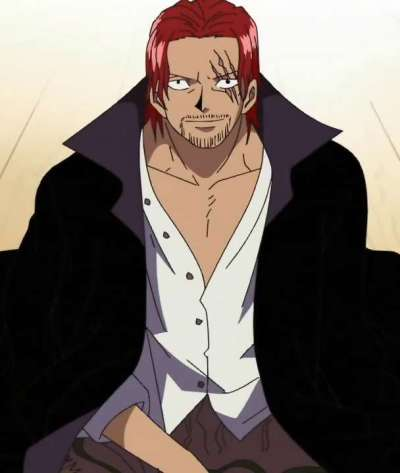

In [ ]:
from PIL import Image
import requests

url = "https://ami.animecharactersdatabase.com/uploads/chars/12602-925960129.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50, temperature=0.7, do_sample=True)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


a man in a pirate costume
